## Assignment 2  

The goal of this assignment is to create a model that can perform sentimental analysis. To achieve this we'll be training it on the provided dataset, that contains 10000 product reviews classified as positive, neutral and negative.

**Required Imports/Downloads**

In [ ]:
%pip install spacy imblearn nltk numpy pandas wordcloud
!python -m spacy download nb_core_news_sm

In [3]:
import numpy as np
import spacy
import re
import nltk
import pickle
import json
import pandas as pd
from spacy.lang.nb import Norwegian
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import BorderlineSMOTE
from wordcloud import WordCloud
from matplotlib import colors
import matplotlib.pyplot as plt

# from nltk.corpus import wordnet as wn

In [4]:
# nltk.download("stopwords")
# nltk.download("wordnet")

### Data-set

We load the data-set into data. Also defines stopwords to be Norwegian using `stopwords.words('norwegian')` and loads the natural language processesing using spaCy. spaCy is an open source software library for natural language processing. It contains a module for Norwegian that can be loaded with `spacy.load('nb_core_news_sm')`.

In [5]:
data = {}
stops = stopwords.words('norwegian')
nlp = spacy.load('nb_core_news_sm')

In [6]:
for name in ["train", "dev", "test"]:
    with open("{0}.json".format(name)) as infile:
        data[name] = json.load(infile)

Next we load the train and test data into data-frames.

In [7]:
train = pd.DataFrame.from_dict(data["train"])
test = pd.DataFrame.from_dict(data["test"])

X_train_raw = train['text']
y_train = train['label']

X_test_raw = test['text']
y_test = test['label']

# train
# test

Once we've put the data-set into dataframes we can poke at it to glean some information. We can use `value_counts('label)` to see the number of neutral, positive, or negative sentiments. Furthermore we can use `sample(n=10)` to view 10 random sentiments form the data-set.

In [15]:
train.value_counts('label')

label
Neutral     4079
Positive    2624
Negative    1270
dtype: int64

In [19]:
train.sample(n=10)

,sent_id,text,label
4521,201835-52-02,Lydutgangen serverer imidlertid noe lav lyd – ...,Negative
3927,202124-02-01,Har du et digitalkamera som er PictBridge-komp...,Positive
5352,305169-07-06,Han spør folk på gata hva de ler av .,Neutral
4556,105571-12-03,Diskuter Metroid Other M her !,Neutral
5588,101562-10-01,Jeg er ikke et øyeblikk i tvil at den troende ...,Neutral
4721,108139-05-02,"Hun smaker på alt ekstremt , også hore-rollen ...",Neutral
4892,703462-07-01,Kanskje er det nettopp disse to tilsynelatende...,Neutral
238,106360-11-03,« Twilight Princess » er så bra at jeg får gås...,Positive
397,700034-08-04,"Som et gnagsår kverner tankene , særlig fordi ...",Neutral
4125,300016-16-01,"Fredag gikk for høstens lam , men også der var...",Negative


### Data processing  
  
The function found below processes the data to make it easier for machine learning to use. Removing words and character that are not useful and reduce the accuracy of the machine learning process.  
  
`Original: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm`  
  
To remove single characters we run this code `re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)`  
To remove single characters at the start of a sentence we run `re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)`
`Removed single characters: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm`  

To remove multiple spaces: `re.sub(r'\s+', ' ', document, flags=re.I)`  
And to make it all lowercase: `document.lower()`

`Lowercase: med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm`  

Once the input text has been lemmatized it looks like the list below, before it gets joined together into a single sentence. Stop words are added at the vectorizer stage

`Lemmatized: ['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']`

In [8]:
stemmer = nlp.get_pipe('lemmatizer')

def clean_text(X: list[str], n_to_print=0):
    documents = []
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))

        if len(documents) < n_to_print:
            print('Original:', document)

        # remove all single characters
        document = re.sub(r'\s+[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-ZæøåÆØÅ]\s+', ' ', document)

        if len(documents) < n_to_print:
            print('Removed single characters:', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        # document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        if len(documents) < n_to_print:
            print('Lowercase:', document)

        # Lemmatization
        document = nlp(document)

        document = [word.lemma_ for word in document]

        if len(documents) < n_to_print:
            print('Lemmatized:', document)
        document = ' '.join(document)

        documents.append(document)
    return documents

### Vectorizer:  
  
The Vectorizer we've chosen for this task is the TfidVectorizer. Tfid stands for "Term Frequence-inverse Document Frequency". The vectorizer converts data to a matrix of said TD-IDF features. It's equivelant to doing a `CountVectorizer` followed by `TfidfTransformer`.  
  
The point of using tf-idf instead of raw-frequencies is to reduce the impact very frequent words and improve the impact of features that occur less frequently. The vectorizer is where we define the stopwords, so that it can be re-used later.

In [9]:
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1,2))

In [10]:
X_train_lemmas = clean_text(X_train_raw, 2)
X_test_lemmas = clean_text(X_test_raw)

X_train = vectorizer.fit_transform(X_train_lemmas).toarray()

# X_train

Original: Philips 190G6
Removed single characters: Philips 190G6
Lowercase: philips 190g6
Lemmatized: ['philips', '190g6']
Original: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Removed single characters: Med integrerte høyttalere som på ingen måte er diskret plassert   og med en stor subwoofer inkludert   da snakker vi om en gutteskjerm  
Lowercase: med integrerte høyttalere som på ingen måte er diskret plassert og med en stor subwoofer inkludert da snakker vi om en gutteskjerm 
Lemmatized: ['med', 'integrert', 'høyttal', 'som', 'på', 'ingen', 'måte', 'være', 'diskre', 'plassere', 'og', 'med', 'en', 'stor', 'subwoof', 'inkludere', 'da', 'snakke', 'vi', 'om', 'en', 'gutteskjerm']


Funny data visualisation

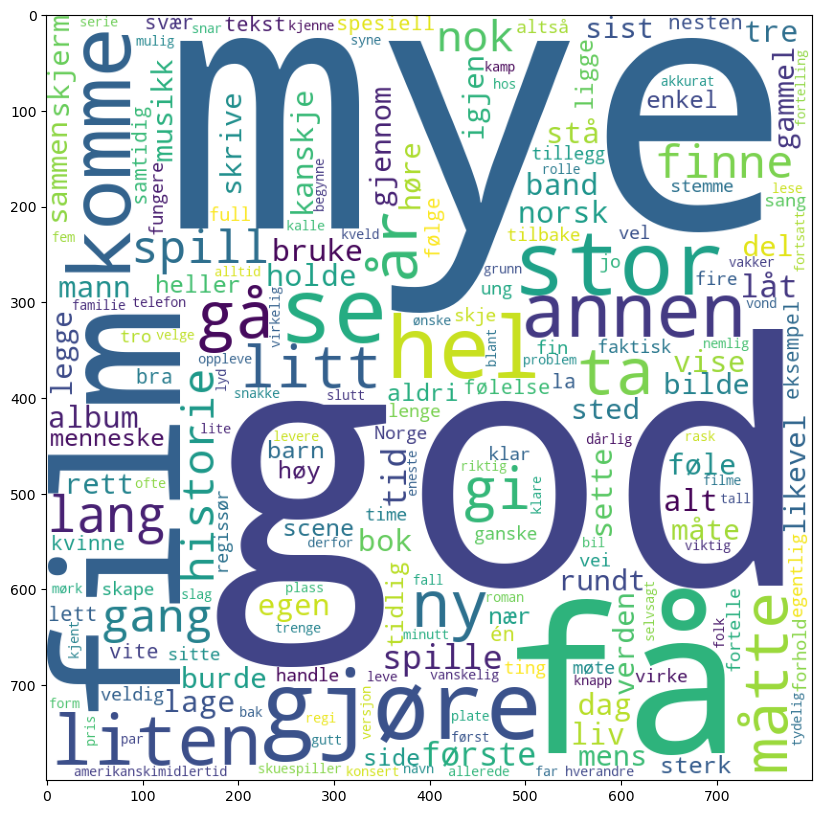

In [11]:
X_train_wc = []

for i in X_train_lemmas:
    for k in i.split():
        if k not in stops:
            X_train_wc.append(k)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate((' '.join(X_train_wc)))

# print(X_train_wc)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.tight_layout(pad = 0)

plt.show()

In [12]:
X_test = vectorizer.transform(X_test_lemmas).toarray()

X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Classifier  
  
For the classifier we've tried several different ones, they all came out about the same accuracy, so in the end we went with SGDClassifier. SGDClassifier is part of sklearn

In [13]:
classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [14]:
print(f'Non-rescaled: {accuracy_score(y_test, y_pred)}')

Non-rescaled: 0.632514817950889


In [15]:
print(confusion_matrix(y_test, y_pred))

[[ 34  84  64]
 [ 22 458 118]
 [ 20 126 255]]


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.45      0.19      0.26       182
     Neutral       0.69      0.77      0.72       598
    Positive       0.58      0.64      0.61       401

    accuracy                           0.63      1181
   macro avg       0.57      0.53      0.53      1181
weighted avg       0.61      0.63      0.61      1181



### Resampler  

As is quite evident now, the data-set is quite skewed. When we called `train.value_counts('label')` earlier we could see that Neutral and Positive sentiment outnumber negative sentiment by quite a lot. So in an attempt to reduce the effect of the data-set being as skewed as it is. We've decided to try to use a resampler to try and equalize the amount of each sentiment. This fills the data-set with an equal amount of each data-type.

In [17]:
resampler = BorderlineSMOTE(random_state=123)

X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)

So let's see how many values it has once resampled vs non-resampled.

In [18]:
y_train_res.value_counts() # Rescaled

Neutral     4079
Negative    4079
Positive    4079
Name: label, dtype: int64

In [19]:
y_train.value_counts() # non-Rescaled

Neutral     4079
Positive    2624
Negative    1270
Name: label, dtype: int64

As you can see the difference in quite huge.  

Now let's see what accuracy it achives when the input-data is equalized.

In [20]:
classifier_res = SGDClassifier()
classifier_res.fit(X_train_res, y_train_res)
y_pred_res = classifier_res.predict(X_test)

In [21]:
print(f'Rescaled: {accuracy_score(y_test, y_pred_res)}')

Rescaled: 0.6121930567315834


In [22]:
print(confusion_matrix(y_test, y_pred_res))

[[ 52  72  58]
 [ 64 420 114]
 [ 40 110 251]]


In [23]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

    Negative       0.33      0.29      0.31       182
     Neutral       0.70      0.70      0.70       598
    Positive       0.59      0.63      0.61       401

    accuracy                           0.61      1181
   macro avg       0.54      0.54      0.54      1181
weighted avg       0.61      0.61      0.61      1181



### Results Discussion  
  a
The results of this sentimental analysis are pretty abysmal, 63% accuracy is practically a coinflip and isn't all that useful to actually perform machine learning with. And once rescaled to try to account for the skewed data-set we're still seeing quite low accuracy. The reason for this could be a poor choice of machine learning, but we think the main issue is that the skewed data-set doesn't give the model enough to go off of.  

Analysing the classification reports we can glean some information about the model. In the first classification report we had a negative recall of `.19`, meaning that out of `100` negative sentences, it would misclassify `81` of them. These numbers are slightly improve in the rescaled classifier, to `.29` negative recall. The numbers of neutral and positive recall are significantly higher, but similarly are also quite poor.  

For negative precision we see it scores `.45` meaning that for 55% of the sentences if the classifier says it's negative, it's wrong. In the rescaled classifier the negative precision actually goes down significantly to `.33`, meaning that for 77% of the sentences the classifiger says is negative is wrong.

              precision    recall  f1-score   support

    Negative       0.45      0.19      0.26       182
     Neutral       0.69      0.77      0.72       598
    Positive       0.58      0.64      0.61       401

    accuracy                           0.63      1181
   macro avg       0.57      0.53      0.53      1181
weighted avg       0.61      0.63      0.61      1181